## Load data

In [1]:
import sys
 
sys.path.insert(0, "../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/feature_variation/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/feature_variation/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/feature_variation/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [3]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_test_gw = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_test_gw = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

X_test_un = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

## Define model

In [4]:
import torch.nn.functional as F
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES

class NeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(NeuralNetwork, self).__init__()
        
        input_dim = len(FEATURES)
        self.lin_0 = Linear(input_dim, hidden_dim)
        self.lin_1 = Linear(input_dim, hidden_dim)
        self.lin_end_0 = Linear(hidden_dim, out_channels)
        self.lin_end_1 = Linear(hidden_dim, out_channels)
        self.batchnorm_1 = torch.nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.lin_0(x) + self.lin_1(x)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x= self.batchnorm_1(x)
        x = self.lin_end_0(x) + self.lin_end_1(x) 
        return x
            
    def predict_proba(self, x):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(x)
            scores = torch.sigmoid(torch.squeeze(logits))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, x):
        return torch.round(self.predict_proba(x)[:, 1])

## Load trained model

In [5]:
model = NeuralNetwork() #.to(device)
model.load_state_dict(torch.load("../models/neural_network_state_dict.pt", map_location=torch.device('cpu')))
model.eval()

NeuralNetwork(
  (lin_0): Linear(in_features=7, out_features=128, bias=True)
  (lin_1): Linear(in_features=7, out_features=128, bias=True)
  (lin_end_0): Linear(in_features=128, out_features=1, bias=True)
  (lin_end_1): Linear(in_features=128, out_features=1, bias=True)
  (batchnorm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
X_all_unnormalized = torch.concat((X_train, X_test, X_test_gw))
y_all = torch.concat((y_train, y_test, y_test_gw))

In [7]:
def normalize(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.from_numpy(tensor).type(torch.float)
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

In [8]:
X_all = normalize(X_all_unnormalized)

In [9]:
y_pred_all = model.predict(X_all)

In [128]:
mean= torch.mean(X_all_unnormalized, dim = 0).numpy()
std = torch.std(X_all_unnormalized, dim = 0).numpy()

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


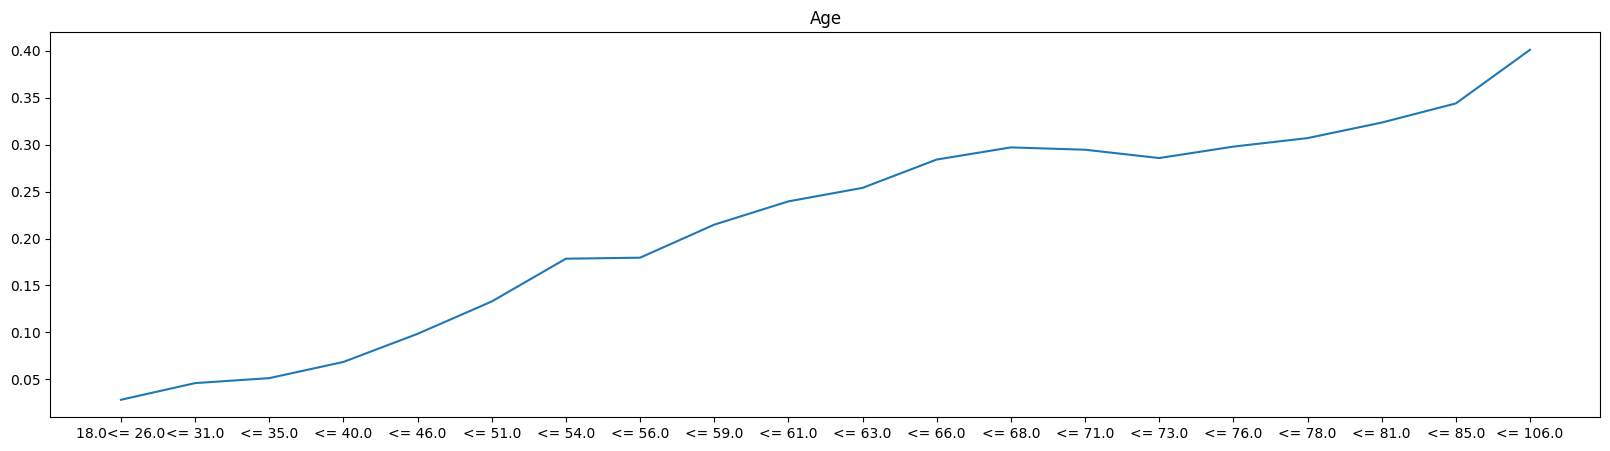

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


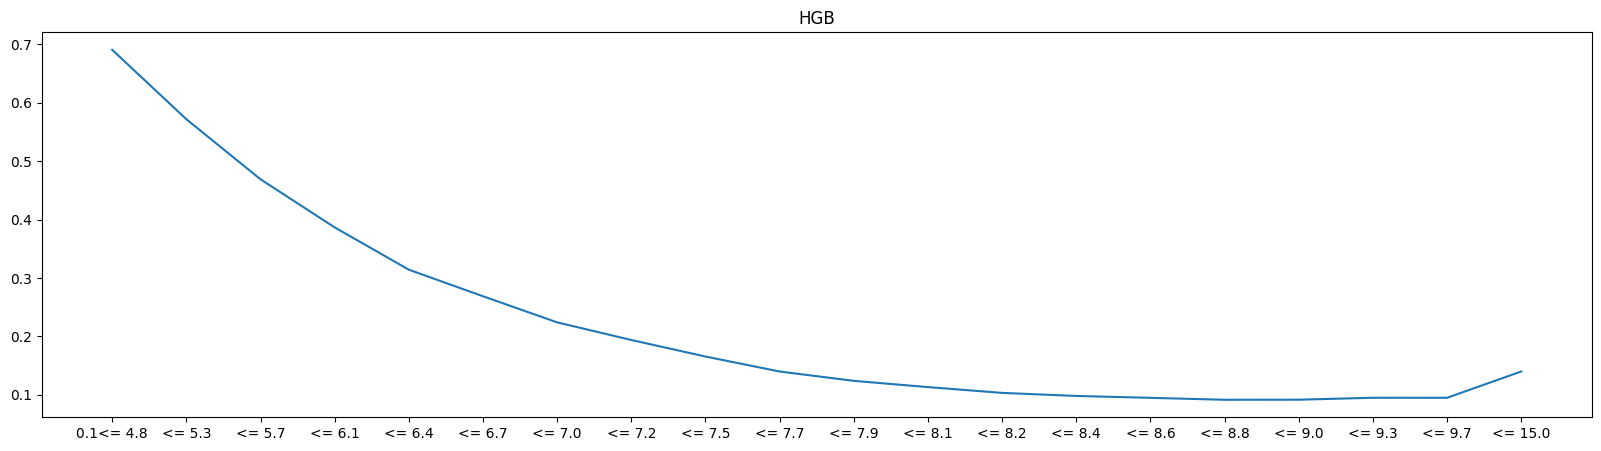

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


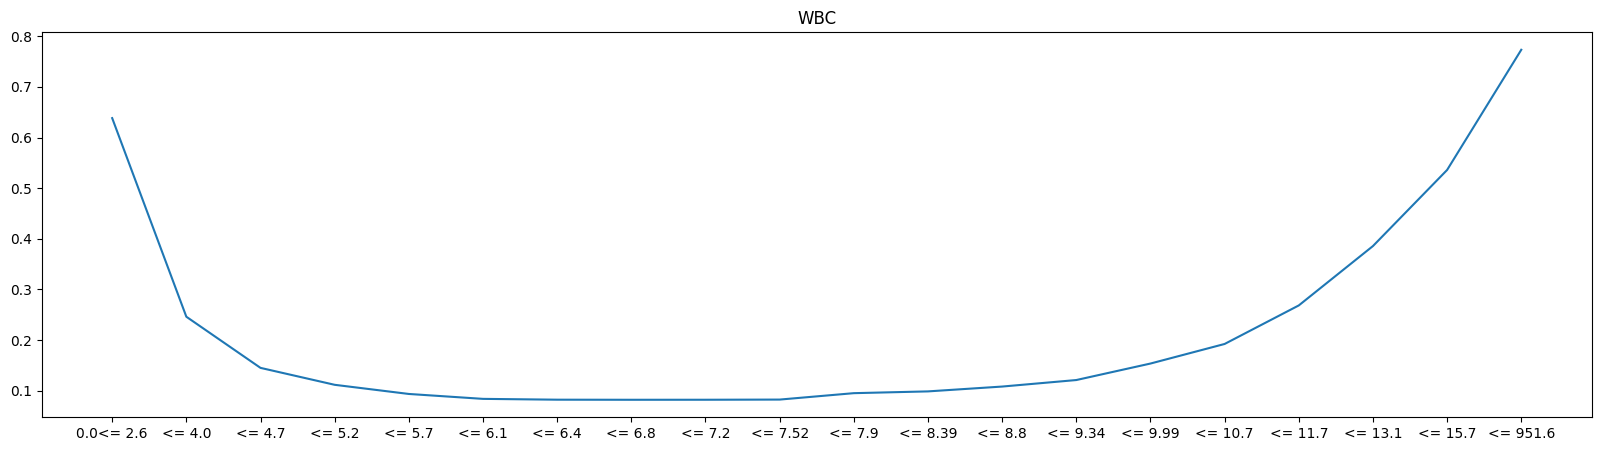

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


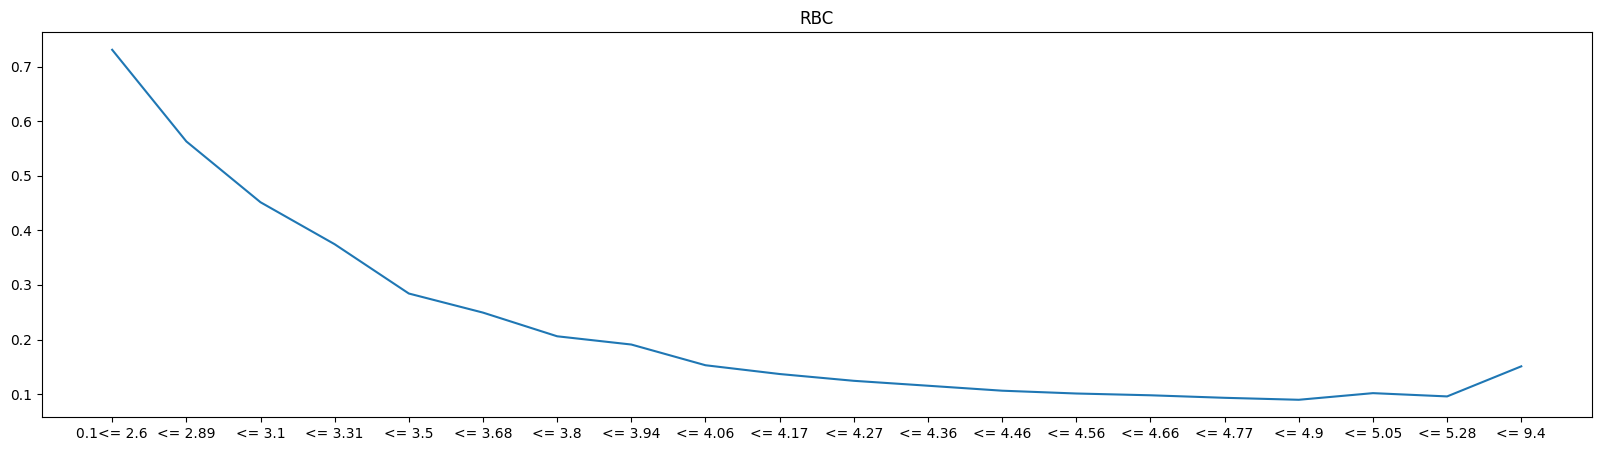

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


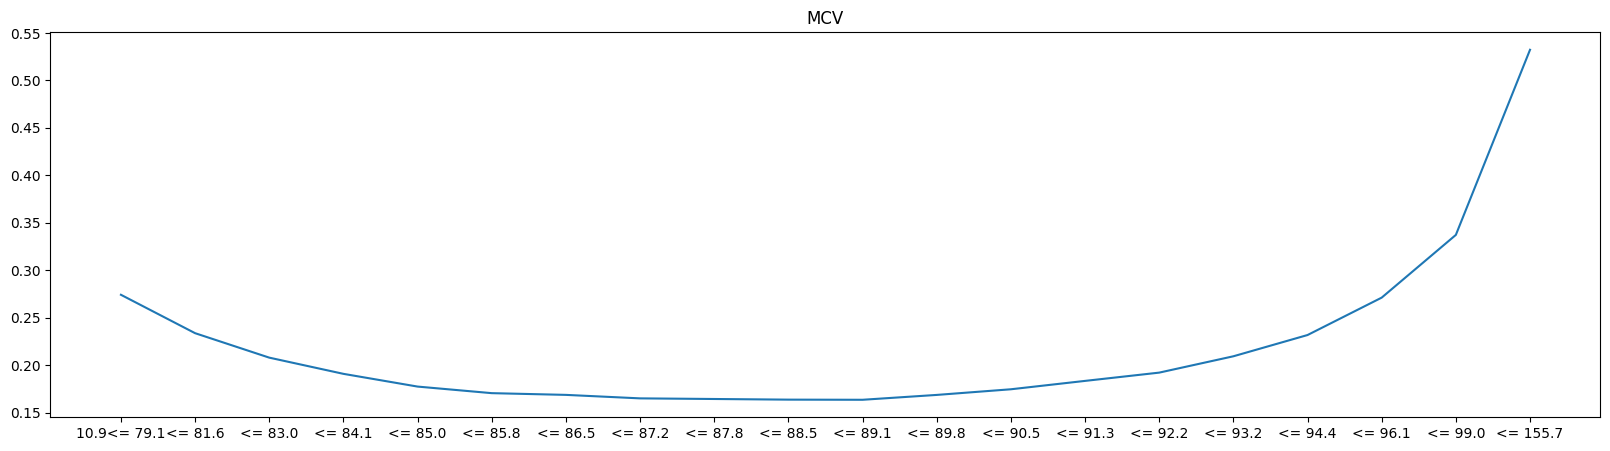

/tmp/ipykernel_2598630/2511163322.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sepsis_ratio = y_pred_all[mask].sum() / mask.sum()


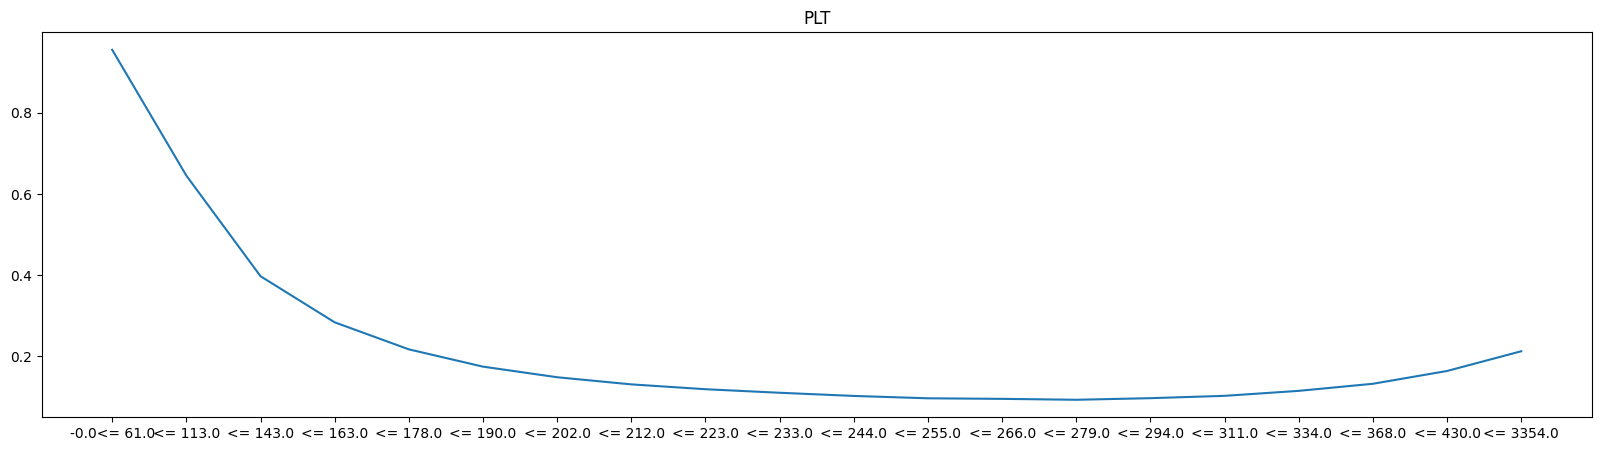

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import os
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME

QUANTILES = 20
quantiles = np.linspace(0, 1, QUANTILES+1, endpoint=True)

for feature_it in range(len(FEATURES)):
    if FEATURES[feature_it] == SEX_CATEGORY_COLUMN_NAME:
        continue
    path = f"{FEATURES[feature_it]}-Real.csv"
    df = pd.read_csv(path) if os.path.isfile(path) else pd.DataFrame()
    tensor_quantiles = np.quantile(X_all[:, feature_it].numpy(), quantiles)
    tensor_quantiles_unnormalized = np.round(tensor_quantiles*std[feature_it] + mean[feature_it], 2)
    x_ticks = [(tensor_quantiles_unnormalized.tolist()[j]+tensor_quantiles_unnormalized.tolist()[j+1]) / 2 for j in range(len(tensor_quantiles_unnormalized.tolist()) - 1)]
    x_labels = [f"{tensor_quantiles_unnormalized.tolist()[j]}<= {tensor_quantiles_unnormalized.tolist()[j+1]}" if j == 0 else f"<= {tensor_quantiles_unnormalized.tolist()[j+1]}" for j in range(len(tensor_quantiles_unnormalized.tolist()) - 1)]
    tensor_quantiles[-1] = tensor_quantiles[-1] + 1e-5
    sepsis_ratios = []
    for i in range(tensor_quantiles.shape[0]-1):
        quantile_u = tensor_quantiles[i]
        quantile_o = tensor_quantiles[i+1]
        mask = np.logical_and(X_all[:, feature_it] >= quantile_u, X_all[:, feature_it] < quantile_o)
        sepsis_ratio = y_pred_all[mask].sum() / mask.sum()
        sepsis_ratios.append(sepsis_ratio.item())
    df["x"] = x_labels
    df["NN"] =sepsis_ratios
    plt.figure(figsize=(20, 5))
    plt.plot(x_labels,  sepsis_ratios)
    plt.title(FEATURES[feature_it])
    plt.show()
    df.to_csv(path, index=False)

In [71]:
sum_ = 0
for mask in masks:
    sum_ += mask.sum()
print(sum_ == X_all.shape[0])

tensor(True)


## Feature importance

In [5]:
from dataAnalysis.FeatureImportance import FeatureImportance

feature_importance = FeatureImportance(X_train, is_normalize=True)

Ratio of diseased men/women over all CBCs for Neural Network 19.513875	17.2621421875


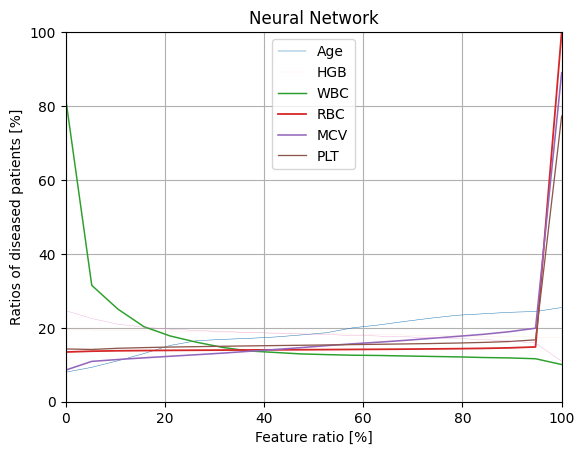

In [6]:
feature_importance.plot_feature_importance(model, title= "Neural Network")

## Test

In [7]:
import numpy as np
from dataAnalysis.Metrics import Evaluation

y_pred_proba_xgb = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred_proba_nn = model.predict_proba(X_test)[:, 1]
mean_scores = np.mean([y_pred_proba_xgb, y_pred_proba_nn.numpy()], axis = 0)
y_pred_proba_new = np.concatenate([np.expand_dims((1-mean_scores), 1), np.expand_dims(mean_scores, 1)], axis=1)


y_dict = Evaluation.create_y_dict(np.round(mean_scores), y_pred_proba_new, y_test)
Evaluation.plot_confusion_matrix_from_pred(np.round(mean_scores), y_test)

/home/dwalke/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


NameError: name 'xgb_classifier' is not defined

In [45]:
from dataAnalysis.FeatureImportance import normalize
X_test = normalize(X_test)

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.051349,0.777225,0.442055,0.009613,0.876709,0.014983
1,Greifswald,0.051349,0.777225,0.442055,0.009613,0.876709,0.014983


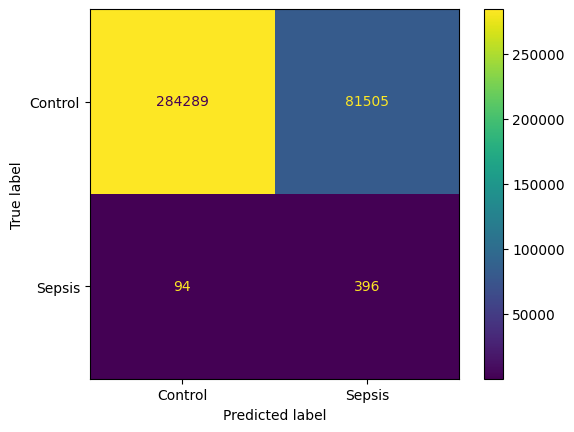

In [65]:
evaluation = Evaluation(y_test, y_test, X_test, X_test)
# evaluation.plot_confusion_matrix(xgb_classifier)


evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model) #, evaluation.get_df_metrics(xgb_classifier)

In [7]:
y_pred = model.predict(X_test)

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.026266,0.233208,0.192617,0.011584,0.742278,0.019049
1,Greifswald,0.026266,0.233208,0.192617,0.011584,0.742278,0.019049


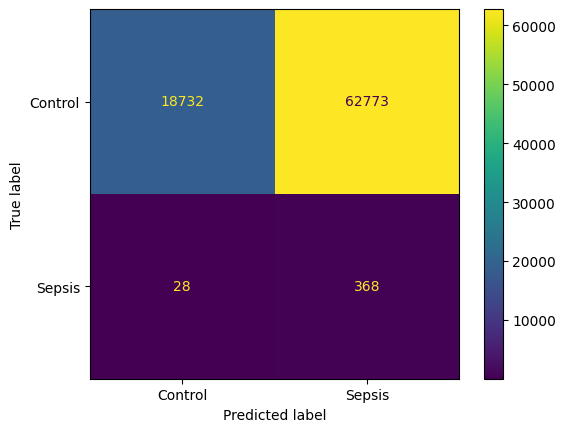

In [70]:
y_test_copy = y_test[y_pred ==  1]
X_test_copy = X_test_un[y_pred ==  1]
evaluation = Evaluation(y_test_copy, y_test_copy, X_test_copy, X_test_copy)

evaluation.plot_confusion_matrix(xgb_classifier)
evaluation.get_df_metrics(xgb_classifier)

In [87]:
evaluation = Evaluation(y_test, y_test, X_test, X_test)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(y_pred_proba.shape)
print((y_pred == 1).shape)
y_new_pred = xgb_classifier.predict(X_test_un[y_pred == 1])
y_new_pred_poba = xgb_classifier.predict_proba(X_test_un[y_pred == 1])

print(y_new_pred.shape)
print(torch.from_numpy(y_new_pred_poba).type(torch.float).shape)
y_pred_proba_clone = y_pred_proba.clone()
y_pred_proba_clone[y_pred == 1] = torch.from_numpy(y_new_pred_poba).type(torch.float)
y_pred[y_pred == 1] = torch.from_numpy(y_new_pred).type(torch.float)
# y_pred_proba[y_pred == 1] = torch.from_numpy(y_new_pred_poba).type(torch.float)


y_dict = Evaluation.create_y_dict(y_pred, y_pred_proba, y_test)
print(y_dict)
evaluation.get_df_metrics_from_pred(y_dict, y_dict)

torch.Size([366284, 2])
torch.Size([366284])
(81901,)
torch.Size([81901, 2])
{'test_pred': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'test_pred_proba': tensor([[0.4734, 0.5266],
        [0.9434, 0.0566],
        [0.8242, 0.1758],
        ...,
        [0.7882, 0.2118],
        [0.7695, 0.2305],
        [0.4290, 0.5710]]), 'y_test': tensor([0, 0, 0,  ..., 0, 0, 0])}


,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.056069,0.828289,0.458772,0.011567,0.876709,0.014983
1,Greifswald,0.056069,0.828289,0.458772,0.011567,0.876709,0.014983


In [48]:
pred = model.predict(X_test)
# false_sepsis = X_test[torch.logical_and(pred != y_test, pred == 1)]
# true_sepsis = X_test[torch.logical_and(pred == y_test, pred == 1)]

In [23]:
from scipy.stats import mannwhitneyu,ttest_ind
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, FEATURES

ALPHA = .05
## ATENTION: Sex is not ordinal scaled so U test is not applicable
def are_features_different(X_control, X_sepsis):
    features_diff = {}
    for i in range(X_control.shape[1]):
        if FEATURES[i] == SEX_CATEGORY_COLUMN_NAME:
            continue
#         U1, p = mannwhitneyu(X_control[:, i], X_sepsis[:, i], method="auto")
        U1, p = ttest_ind(X_control[:, i], X_sepsis[:, i])
        print(FEATURES[i])
        print(p)
        features_diff[FEATURES[i]] = p <= ALPHA
    return features_diff

are_features_different(false_sepsis, true_sepsis)

Age
0.106558747983859
HGB
4.621067325132585e-12
WBC
1.2998501464437748e-20
RBC
1.3342045880851953e-13
MCV
0.01286303895062097
PLT
1.3925701199284088e-10


{'Age': False, 'HGB': True, 'WBC': True, 'RBC': True, 'MCV': True, 'PLT': True}

In [6]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', 
                           scale_pos_weight = 660,
                           n_estimators=478,
                           max_depth=2,
                           eta=0.1,
                           min_child_weight = 7,
                           max_delta_step= 7,
                           sampling_method= "uniform")
xgb_classifier.fit(data_analysis.get_X_train(), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=7, max_depth=2, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=478,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.051333,0.849929,0.47227,0.025838,0.686872,0.014983
1,Greifswald,0.051333,0.849929,0.47227,0.025838,0.686872,0.014983


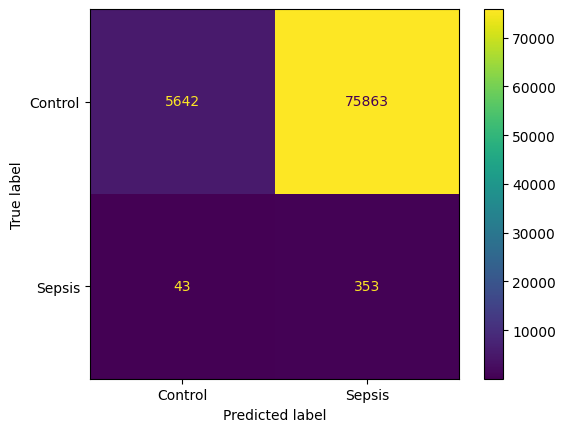

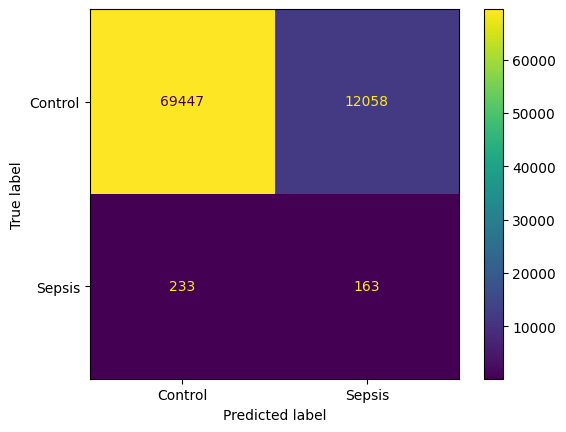

In [39]:

X_clone_test = torch.clone(torch.from_numpy(data_analysis.get_X_test())).type(torch.float)
X_clone_test = normalize(X_clone_test[pred == 1])
y_clone_test = torch.clone(y_test[pred == 1])

from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_clone_test, y_clone_test, X_clone_test, X_clone_test)
evaluation.plot_confusion_matrix(xgb_classifier)
evaluation.get_df_metrics(xgb_classifier)

evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

In [33]:
import torch

# Create a matrix with shape (100, 10)
matrix = torch.randn(100, 10)
print(matrix)

# Create a boolean mask with shape (100,)
mask = torch.tensor([True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False,
                     True, False, True, False, True, False, True, False, True, False])

# Filter the rows based on the boolean mask
filtered_matrix = matrix[mask]

# Check the shape of the filtered matrix
print(filtered_matrix.shape)


tensor([[ 9.0021e-01,  2.2252e-02,  1.0328e+00,  1.9863e+00,  1.1119e-01,
          1.2813e+00,  1.1882e+00,  5.0840e-01,  3.5917e-01, -2.6557e-01],
        [-6.8061e-01, -1.7130e+00,  2.2805e-02, -1.5005e+00,  1.2000e-02,
          1.3892e-01, -1.3879e+00,  7.0655e-01,  1.6234e-01, -1.0113e+00],
        [-1.5294e+00,  1.8404e-01,  4.8820e-01, -7.2131e-01, -8.8162e-01,
          1.1523e-02, -6.4677e-01, -7.3660e-01, -6.4233e-01, -1.8075e-01],
        [ 2.0477e-01, -3.3595e-01,  1.4500e-01, -1.4251e+00, -3.1376e-01,
          1.3419e-01,  8.7584e-01,  7.1222e-01,  8.0283e-01,  1.0058e+00],
        [ 4.7987e-01,  2.3946e-01, -4.8174e-01,  5.5793e-01, -4.9575e-01,
         -1.6269e+00, -1.0122e+00,  4.0751e-01, -6.7145e-01,  6.5901e-01],
        [ 6.7088e-01, -5.8487e-02,  1.7153e+00, -4.4082e-01, -1.1611e+00,
         -3.9434e-01, -8.2604e-01, -9.3865e-01, -3.4159e-01, -8.6425e-01],
        [ 3.4950e-01,  2.4386e-01,  3.5634e-01, -1.9770e-01, -8.7115e-02,
          1.7026e-02, -1.9223e+0

In [73]:
import torch

# Example input tensor
tensor = torch.tensor([1, 2, 3, 1, 4, 5, 1])

# Value to be replaced
old_value = 1

# New values (corresponding to each occurrence of old_value)
new_values = torch.tensor([10, 20, 30])

# Create a mask for the positions of old_value
mask = tensor == old_value

# Count the number of occurrences of old_value
num_occurrences = mask.sum().item()

# Check if the number of new values matches the number of occurrences
if len(new_values) != num_occurrences:
    raise ValueError("Number of new values does not match the number of occurrences")

# Replace old_value with new_values
tensor[mask] = new_values

# Print the modified tensor
print(tensor)


tensor([10,  2,  3, 20,  4,  5, 30])
